# Mobilenetv2 for Testing - Take 2
We are going to use a mobilnet to train a model and see how it does

____


## Loading Packages

In [1]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
gpus=tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)


In [2]:
from utils import DataGenerator, Plot_Val_Test

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 #for our model

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers



## Reading in CSV Data and creating Generators

In [3]:
CSV = pd.read_csv('../Data/train_extra.csv')
Counts_Per_Class = 750
# Balancing the Classes


# spling into train and validate
Idx_Split = np.random.uniform(size = CSV.shape[0])
CSV_Val = CSV[Idx_Split <= 0.2].copy().reset_index()
CSV_Train = CSV[Idx_Split > 0.2].copy().reset_index()

#rebalcing CSV_train
if False:
    CSV_Train['index'] = CSV_Train.index
    Re_Index = CSV_Train.groupby('grapheme_root').index.apply(lambda x: x.sample(n=1000, replace=True))
    CSV_Train = CSV_Train.loc[Re_Index.index.droplevel(),:]
    CSV_Train.reset_index(inplace = True)
    CSV_Train.drop(columns = ['index','level_0'], inplace = True)

print("Shape of Train is: {} x {} \nShape of Val is {} x {}".format(CSV_Train.shape[0], 
                                                                    CSV_Train.shape[1],
                                                                    CSV_Val.shape[0], 
                                                                    CSV_Val.shape[1]))


Shape of Train is: 160562 x 7 
Shape of Val is 40278 x 7


In [4]:
CSV.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme,Image_Dir
0,Train_0,15,9,5,ক্ট্রো,../Data/Train/Train_0.jpg
1,Train_1,159,0,0,হ,../Data/Train/Train_1.jpg
2,Train_2,22,3,5,খ্রী,../Data/Train/Train_2.jpg
3,Train_3,53,2,2,র্টি,../Data/Train/Train_3.jpg
4,Train_4,71,9,5,থ্রো,../Data/Train/Train_4.jpg


In [5]:
Gen_Train = DataGenerator(
                csv_file = CSV_Train,
                 y_var = 'grapheme_root', # 'consonant_diacritic',
                 to_fit=True,
                 batch_size=120, #160,
                 dim = (90,160),
                 channels = 1,
                 vertical_flip = 0,
                 horizontal_flip = 0,
                 rotate = (0.2,180), #PRob, max roatioan
                 shear = (0.2,0.9), # prob, max_shear
                 shuffle=True,
                sample_classes = 750,
                save_model_path = '../Data/Best_Model_eva.hdf5')

Gen_Val = DataGenerator(
                csv_file = CSV_Val,
                 y_var = 'grapheme_root', # 'consonant_diacritic',
                 to_fit=True,
                 batch_size=160,
                 dim = (90,160),
                 channels = 1,
                 vertical_flip = 0,
                 horizontal_flip = 0,
                 rotate = (0,0), #Prob, max roatioan
                 shear = (0,0), # prob, max_shear
                 shuffle=True,
                 sample_classes = 0)


print("Target has {} values,\nnumber of batches per epoch is {} x {}".format(Gen_Train.y.shape[1],
                                                                                 len(Gen_Train),
                                                                                 len(Gen_Val)))

Number of Encodings is 168
Number of Encodings is 168
Target has 168 values,
number of batches per epoch is 1050 x 251


## Loading Model

In [6]:
def build_MNV2(input_shape: tuple,
               alpha: int = 1,
               weights: list = None,
               dropout_per: float = 0.2,
               target_size: int = 168,
              learning_rate: float = 0.0002):
    mobilenetV2 = MobileNetV2(
                input_shape = input_shape,
                alpha = alpha,
                weights=weights,
                include_top=False)

    #Making all layers in MobilenetV2 trainable!
    for layer in mobilenetV2.layers:
        layer.trainable = True

    model = Sequential()
    model.add(mobilenetV2)
    model.add(layers.GlobalMaxPooling2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation = 'relu'))
    model.add(layers.Dropout(dropout_per))
    model.add(layers.Dense(512, activation = 'relu'))
    model.add(layers.Dropout(dropout_per))
    model.add(layers.Dense(256, activation = 'relu'))
    model.add(layers.Dropout(dropout_per))
    model.add(layers.Dense(target_size, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizers.Adam(lr=learning_rate),
        #optimizer = optimizers.RMSprop(learning_rate = learning_rate )    ,
        metrics=['accuracy']
        )

    return model


def build_minst_big(input_shape,
                dropout_per,
               target_size,
               learning_rate = 0.0002):
    
    mnst_model = Sequential([
    # This is the first convolution
    layers.Conv2D(128, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(2, 2),
    # The second convolution
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    # The third convolution
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    # The forth Conco
    layers.Conv2D(16, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    layers.Flatten(),
    # 512 neuron hidden layer
    layers.Dense(512, activation='relu'),
    layers.Dropout(dropout_per),
        
#    layers.Dense(256, activation='relu'),
#    layers.Dropout(dropout_per),
        
    layers.Dense(target_size, activation='softmax')
    ])

    mnst_model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizers.Adam(lr=learning_rate),
        #optimizer = optimizers.RMSprop(learning_rate = learning_rate )    ,
        metrics=['accuracy']
        )
    return mnst_model
    
def build_minst(input_shape,
                dropout_per,
               target_size,
               learning_rate = 0.0002):
    
    mnst_model = Sequential([
    # This is the first convolution
    layers.Conv2D(16, (3,3), activation='relu', input_shape=input_shape),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    # The second convolution
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    # The third convolution
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.Conv2D(8, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    layers.Flatten(),
    # 512 neuron hidden layer
    layers.Dense(512, activation='relu'),
    layers.Dropout(dropout_per),
        
    layers.Dense(256, activation='relu'),
    layers.Dropout(dropout_per),
        
    layers.Dense(target_size, activation='softmax')
    ])

    mnst_model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizers.Adam(lr=learning_rate),
        #optimizer = optimizers.RMSprop(learning_rate = learning_rate )    ,
        metrics=['accuracy']
        )
    return mnst_model


def build_minst2(input_shape,
                dropout_per,
               target_size,
               learning_rate = 0.0002):
    
    mnst_model = Sequential([
    # This is the first convolution
    layers.Conv2D(16, (3,3), activation='relu', input_shape=input_shape),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    # The second convolution
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    # The third convolution
    layers.Conv2D(16, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    layers.Flatten(),
    # 512 neuron hidden layer
    layers.Dense(512, activation='relu'),
    layers.Dropout(dropout_per),
        
    layers.Dense(256, activation='relu'),
    layers.Dropout(dropout_per),
        
    layers.Dense(target_size, activation='softmax')
    ])

    mnst_model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizers.Adam(lr=learning_rate),
        #optimizer = optimizers.RMSprop(learning_rate = learning_rate )    ,
        metrics=['accuracy']
        )
    return mnst_model

def build_springer(input_shape,
                dropout_per,
               target_size,
               learning_rate = 0.0002,
                return_features = True):
    """Model based on this paper for character recognition
    https://link.springer.com/article/10.1007/s11036-019-01243-5
    """
    mnst_model = Sequential([
    # This is the first convolution
    layers.Conv2D(128, (5,5), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(2, 2),
    # The second convolution
    layers.Conv2D(128, (5,5), activation='relu'),
    layers.MaxPooling2D(2,2),
    # The third convolution
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    # The Forth Layer
    layers.Conv2D(128, (3,3), activation='relu'),
    # Flatten the results to feed into a DNN
    layers.Flatten(),
    # 512 neuron hidden layer
    layers.Dense(512, activation='relu'),
    # drop out layer
    layers.Dropout(dropout_per),
    layers.Dense(target_size, activation='softmax')
    ])

    mnst_model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizers.Adam(lr=learning_rate),
        #optimizer = optimizers.RMSprop(learning_rate = learning_rate )    ,
        metrics=['accuracy']
        )
    
    return mnst_model
def build_mini_minst(input_shape,
                dropout_per,
               target_size,
               learning_rate = 0.0002):
    
    mnst_model = Sequential([
    # This is the first convolution
    layers.Conv2D(20, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(2, 2),
    # The second convolution
    layers.Conv2D(10, (3,3), activation = 'relu'),
    layers.MaxPooling2D(2,2),
    # Third layer
    layers.Conv2D(5, (3,3), activation = 'relu'),
    layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    layers.Flatten(),
    # 512 neuron hidden layer
    layers.Dense(256, activation='relu'),
    # drop out layer
    layers.Dropout(dropout_per),
    layers.Dense(target_size, activation='softmax')
    ])

    mnst_model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizers.Adam(lr=learning_rate),
        #optimizer = optimizers.RMSprop(learning_rate = learning_rate )    ,
        metrics=['accuracy']
        )
    return mnst_model

In [7]:
model = build_MNV2(input_shape = (90,160,1), dropout_per = 0.4, target_size = 168, learning_rate =  0.00001)
model.load_weights('../Data/Model/MobileNet-20200215.wgt')
#model = build_minst(input_shape = (90,160,1), dropout_per = 0.5, target_size = 168, learning_rate = 0.001)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_90 (Model)  (None, 3, 5, 1280)        2257408   
_________________________________________________________________
global_max_pooling2d (Global (None, 1280)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0

In [8]:

#history = model.fit_generator(
history = model.fit(
    Gen_Train,
    #epochs=30,
    epochs=5,
    verbose=1,
    workers=16,
    validation_data = Gen_Val)


Train for 1050 steps, validate for 251 steps
Epoch 1/5
1050/1050 [==============================] - 200s 191ms/step - loss: 0.5505 - accuracy: 0.8777 - val_loss: 0.3925 - val_accuracy: 0.9053
Epoch 2/5
 293/1050 [=======>......................] - ETA: 2:13 - loss: 0.5324 - accuracy: 0.8797

KeyboardInterrupt: 

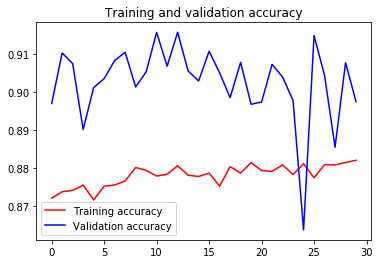

<Figure size 432x288 with 0 Axes>

In [10]:
Plot_Val_Test(history)

In [11]:
model.save_weights('../Data/Model/MobileNet-20200215.wgt')

In [263]:

import random
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
#horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
#human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
#img_path = random.choice(horse_img_files + human_img_files)

img = cv2.imread('../Data/Train/Train_1.jpg', cv2.IMREAD_GRAYSCALE)  # this is a PIL image
x = img.reshape(1,90,160,1) # Numpy array with shape (150, 150, 3)
x = x / 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    print(feature_map.shape)
    if len(feature_map.shape) > 0 :
        print('nice')
        # Just do this for the conv / maxpool layers, not the fully-connected layers
        n_features = feature_map.shape[-1]  # number of features in feature map
        # The feature map has shape (1, size, size, n_features)
        size = feature_map.shape[1]
        # We will tile our images in this matrix
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            # Postprocess the feature to make it visually palatable
            #x = feature_map[0, :, :, i]
            x = feature_map[0, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            # We'll tile each filter into this big horizontal grid
        display_grid[:, i * size : (i + 1) * size] = x
        # Display the grid
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
     plt.imshow(display_grid, aspect='auto', cmap='viridis')

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 53)

In [1]:
import random
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model23.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = Model(inputs = model23.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
#horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
#human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
#img_path = random.choice(horse_img_files + human_img_files)

img = cv2.imread('/home/beltain/Data/fmnist/img_0.jpg', cv2.IMREAD_GRAYSCALE)  # this is a PIL image
x = img.reshape(1,28,28,1) # Numpy array with shape (150, 150, 3)
x = x / 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model23.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    print(feature_map.shape)
    if len(feature_map.shape) > 0 :
        print('nice')
        # Just do this for the conv / maxpool layers, not the fully-connected layers
        n_features = feature_map.shape[-1]  # number of features in feature map
        # The feature map has shape (1, size, size, n_features)
        size = feature_map.shape[1]
        # We will tile our images in this matrix
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            # Postprocess the feature to make it visually palatable
            #x = feature_map[0, :, :, i]
            x = feature_map[0, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            # We'll tile each filter into this big horizontal grid
        display_grid[:, i * size : (i + 1) * size] = x
        # Display the grid
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

NameError: name 'model23' is not defined